In [1]:
import tensorflow as tf
sess = tf.Session()
from keras import backend as K
K.set_session(sess)
from osgeo import ogr, osr

import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os

import rasterio
from rasterio.transform import from_origin
from tqdm import tnrange, tqdm_notebook
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox, constants
from scipy.ndimage import median_filter
from skimage.transform import resize

Using TensorFlow backend.


In [2]:
model = "../../models/unet-resnet/new/34-65-9/"
new_saver = tf.train.import_meta_graph(model + "model.meta")
new_saver.restore(sess, tf.train.latest_checkpoint(model))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../../models/unet-resnet/new/34-65-9/model


In [3]:
def fspecial_gauss(size, sigma):

    """Function to mimic the 'fspecial' gaussian MATLAB function
    """

    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g

arr = fspecial_gauss(14, 3.5)
arr = arr[:7, :7]


SIZE = 9
SIZE_N = SIZE*SIZE
SIZE_UR = (SIZE - 1) * (SIZE - 1)
SIZE_R = (SIZE - 1) * SIZE
SIZE_U = SIZE_R
TOTAL = SIZE_N + SIZE_UR + SIZE_R + SIZE_U
print(SIZE_N, SIZE_UR, SIZE_R, SIZE_U, TOTAL)


arr = np.concatenate([arr, np.flip(arr, 0)], 0)
base_filter = np.concatenate([arr, np.flip(arr, 1)], 1)
normal = np.tile(base_filter, (SIZE, SIZE))
normal[:, 0:7] = 1.
normal[:, -7:] = 1.
normal[0:7, :] = 1.
normal[-7:, :] = 1.
upright = np.tile(base_filter, (SIZE - 1, SIZE - 1))
upright = np.pad(upright, (7, 7), 'constant', constant_values = 0)
right_filter = np.tile(base_filter, (SIZE, SIZE - 1))
right_filter = np.pad(right_filter, ((0, 0), (7, 7)), 'constant', constant_values = 0)
up_filter = np.tile(base_filter, (SIZE - 1, SIZE))
up_filter = np.pad(up_filter, ((7, 7), (0, 0)), 'constant', constant_values = 0)

sums = (up_filter + right_filter + upright + normal)
up_filter /= sums
right_filter /= sums
upright /= sums
normal /= sums

81 64 72 72 289


In [4]:
# December 10-11 model, validated-size, filled in by train-l2a-dec

min_all = [0.01872335869818926,
 0.03467957343906164,
 0.021185510214418172,
 0.08898216009140014,
 0.052402322441339494,
 0.07628638863563539,
 0.083824477866292,
 0.08768215030431747,
 0.05718051139265299,
 0.0372315139323473,
 0.0,
 0.007564654648303981,
 -0.019136652257293465,
 0.0064204379683360435,
 0.006225000135600567,
 4.999999873689376e-05]

max_all = [0.20792677521705638,
 0.2990041905641556,
 0.4360648360848427,
 0.5161105132102968,
 0.4825860628485681,
 0.4943232241272928,
 0.5178957056999209,
 0.5291672283411026,
 0.6659183305501939,
 0.6092100739479065,
 0.37346625328063965,
 0.7162704998254776,
 0.40363759160041823,
 0.6478493613004686,
 0.8438000082969666,
 0.15365000069141388]

def tile_images(arr, output_folder):
    i = 0
    # Normal
    images = []
    for x_offset, cval in enumerate([x for x in range(0, 126, 14)]):
        for y_offset, rval in enumerate([x for x in range(0, 126, 14)]):
            base_id = 0
            subs = arr[:, cval:cval+16, rval:rval+16]
            images.append(subs)
            
    # Upright        
    for x_offset, cval in enumerate([x for x in range(7,  119, 14)]):
        for y_offset, rval in enumerate([x for x in range(7, 119, 14)]):
            base_id = 9*9
            subs = arr[:, cval:cval+16, rval:rval+16]
            images.append(subs)
            
    # Right
    for x_offset, cval in enumerate([x for x in range(7, 119, 14)]):
        for y_offset, rval in enumerate([x for x in range(0, 126, 14)]):
            base_id = (9*9)+(8*8)
            subs = arr[:, cval:cval+16, rval:rval+16]
            images.append(subs)
            
    # Up
    for x_offset, cval in enumerate([x for x in range(0, 119, 14)]):
        for y_offset, rval in enumerate([x for x in range(7, 119, 14)]):
            base_id = (9*9)+(8*8)+(9*8)
            subs = arr[:, cval:cval+16, rval:rval+16]
            images.append(subs)
    return images

def load_and_predict_folder(y_col, folder, location, overlap_filter = upright, normal_filter = normal):
    pred_files = ["../../tile_data/" + location + "/processed/" + str(y_col) + "/" + str(folder) + ".npy"]
    pred_x = []
    
    clipping_params = {
        'rmax': rmax,
        'rmin': rmin,
        'dmax': dmax
    }

    for i in range(len(pred_files)):
        x = np.load(pred_files[0])
        
        filtered = median_filter(x[0, :, :, 10], size = 5)
        filtered = np.reshape(filtered, (64, 2, 64, 2))
        filtered = np.mean(filtered, axis = (1, 3))
        filtered = resize(filtered, (128, 128), 0)
        x[:, :, :, 10] = np.stack([filtered] * 24)
        x = np.delete(x, 14, -1)
        x = tile_images(x, None)
  
    pred_x = np.stack(x)     
    
    for x in range(0, pred_x.shape[-1]):
        mins = min_all[x]
        maxs = max_all[x]
        pred_x[:, :, :, :, x] = np.clip(pred_x[:, :, :, :, x], mins, maxs)
        midrange = (maxs + mins) / 2
        rng = maxs - mins
        standardized = (pred_x[:, :, :, :, x] - midrange) / (rng / 2)
        pred_x[:, :, :, :, x] = standardized
        
    pred_x = np.mean(pred_x, axis = 1)

    preds = []
    batches = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 289]
    for i in range(len(batches)-1):
        batch_x = pred_x[batches[i]:batches[i+1]]
        batch_pred = sess.run(logits, feed_dict={inp:batch_x, 
                                                 clipping_params['rmax']: 5,
                                                 clipping_params['rmin']: 0,
                                                 clipping_params['dmax']: 3}).reshape(batch_x.shape[0], 14, 14)
        for sample in range(batch_pred.shape[0]):
            preds.append(batch_pred[sample, :, :])
            
    preds_stacked = []
    for i in range(0, SIZE_N, SIZE):
        preds_stacked.append(np.concatenate(preds[i:i + SIZE], axis = 1))
    stacked = np.concatenate(preds_stacked, axis = 0)
    stacked = stacked * normal
    preds_overlap = []
    for scene in range(SIZE_N, SIZE_N+SIZE_UR, SIZE - 1):
        to_concat = np.concatenate(preds[scene:scene+ (SIZE - 1)], axis = 1)
        preds_overlap.append(to_concat)    
    overlapped = np.concatenate(preds_overlap, axis = 0)
    overlapped = np.pad(overlapped, (7, 7), 'constant', constant_values = 0)
    overlapped = overlapped * upright

    preds_up = []
    for scene in range(SIZE_N+SIZE_UR, SIZE_N+SIZE_UR+SIZE_R, SIZE):
        to_concat = np.concatenate(preds[scene:scene+SIZE], axis = 1)
        preds_up.append(to_concat)   
    up = np.concatenate(preds_up, axis = 0)
    up = np.pad(up, ((7,7), (0,0)), 'constant', constant_values = 0)
    up = up * up_filter
        
    preds_right = []
    for scene in range(SIZE_N+SIZE_UR+SIZE_R, TOTAL, SIZE - 1):
        to_concat = np.concatenate(preds[scene:scene+SIZE-1], axis = 1)
        preds_right.append(to_concat)   
    right = np.concatenate(preds_right, axis = 0)
    right = np.pad(right, ((0, 0), (7, 7)), 'constant', constant_values = 0)
    right = right * right_filter
    
    stacked = stacked + overlapped + right + up
    return stacked

In [5]:
for i in range(50):
    try:
        logits = tf.get_default_graph().get_tensor_by_name("conv2d_{}/Sigmoid:0".format(i))
    except Exception:
        pass

In [6]:
#logits = tf.get_default_graph().get_tensor_by_name("conv2d_11/Sigmoid:0")
inp = tf.get_default_graph().get_tensor_by_name("Placeholder:0")
rmax = tf.get_default_graph().get_tensor_by_name("Placeholder_4:0")
rmin = tf.get_default_graph().get_tensor_by_name("Placeholder_5:0")
dmax = tf.get_default_graph().get_tensor_by_name("Placeholder_6:0")

# Tanzania

In [33]:
from time import sleep
all_preds = []
for row in tnrange(0, 5):
    pred_i = [load_and_predict_folder(row, col, "tanzania") for col in range(0, 5)]
    pred_i = np.concatenate(pred_i, axis = 1)
    all_preds.append(pred_i)
    sleep(3)
all_preds.reverse()
stacked = np.concatenate(all_preds, axis = 0)

In [59]:
stacked = np.concatenate(all_preds, axis = 0)
stacked[np.isnan(stacked)] = 0.
stacked[np.where(stacked >= 0.47)] = 1.
stacked[np.where(stacked < 0.47)] = 0.

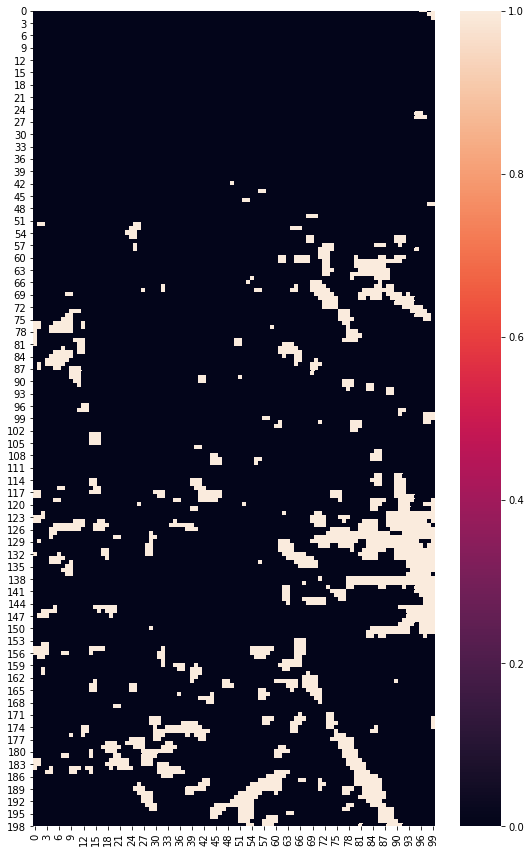

In [60]:
plt.figure(figsize=(9, 15))
sns.heatmap(stacked[398:-31, 400:500])

# Ghana

In [27]:
from time import sleep
all_preds = []
for row in tnrange(0, 5):
    pred_i = [load_and_predict_folder(row, col, "ghana_cocoa") for col in range(0, 5)]
    pred_i = np.concatenate(pred_i, axis = 1)
    all_preds.append(pred_i)
    sleep(3)
all_preds.reverse()
stacked = np.concatenate(all_preds, axis = 0)

In [31]:
stacked = np.concatenate(all_preds, axis = 0)
stacked[np.where(stacked >= 0.4)] = 1.
stacked[np.where(stacked < 0.4)] = 0.

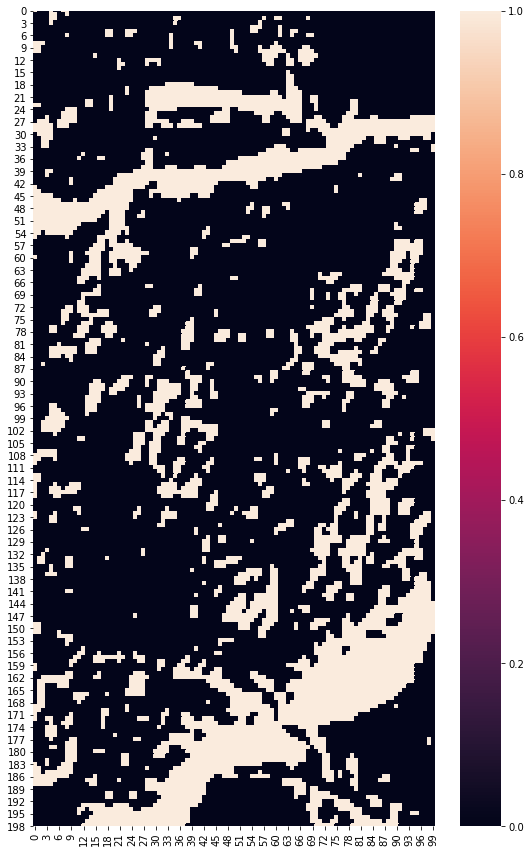

In [32]:
plt.figure(figsize=(9, 15))
# HONDURAS IS 200:400, 540:640 in (5, 10 row), (10, 20 coly)
sns.heatmap(stacked[250:450, 350:450])

# Honduras

In [13]:
from time import sleep
all_preds = []
for row in tnrange(5, 10):
    pred_i = [load_and_predict_folder(row, col, "honduras") for col in range(10, 20)]
    pred_i = np.concatenate(pred_i, axis = 1)
    all_preds.append(pred_i)
    sleep(3)
all_preds.reverse()
stacked = np.concatenate(all_preds, axis = 0)

In [25]:
stacked = np.concatenate(all_preds, axis = 0)
stacked[np.where(stacked >= 0.71)] = 1.
stacked[np.where(stacked < 0.71)] = 0.

/Users/john.brandt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater_equal
  
/Users/john.brandt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


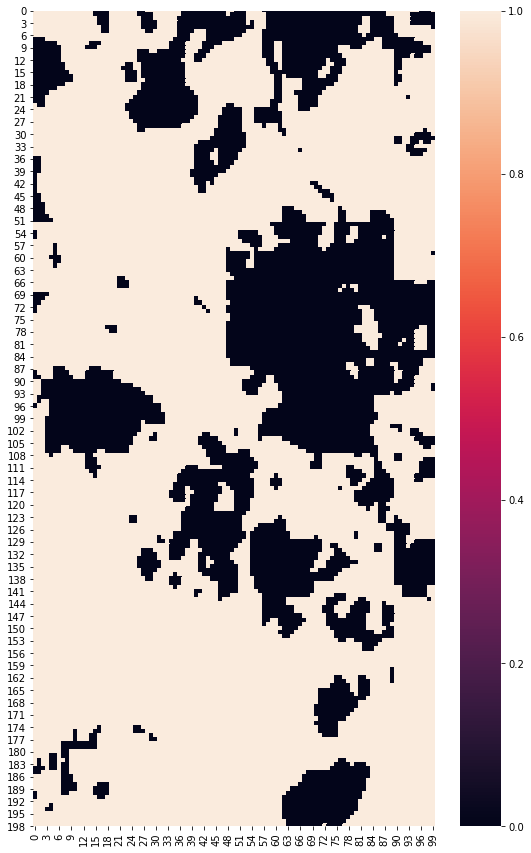

In [26]:
plt.figure(figsize=(9, 15))
# HONDURAS IS 200:400, 540:640 in (5, 10 row), (10, 20 coly)
sns.heatmap(stacked[200:400, 540:640])

# Senegal

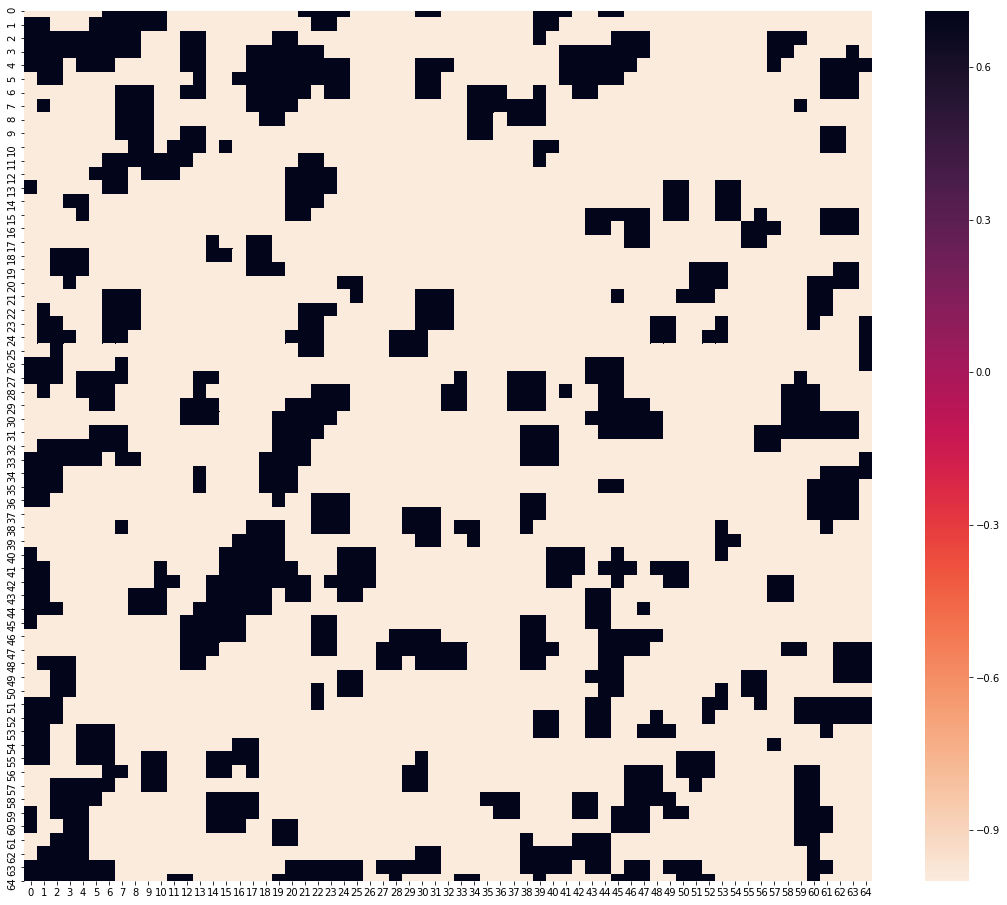

In [22]:
plt.figure(figsize=(19, 16)) # : ,96:155
sns.heatmap(stacked[340:405, 98:163], cmap = sns.cm.rocket_r)